In [158]:
%pip install pandas numpy matplotlib seaborn scikit-learn
%pip install fastapi uvicorn joblib pydantic


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [159]:
import pandas as pd

dataset = pd.read_csv('Telco-Customer-Churn.csv')
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


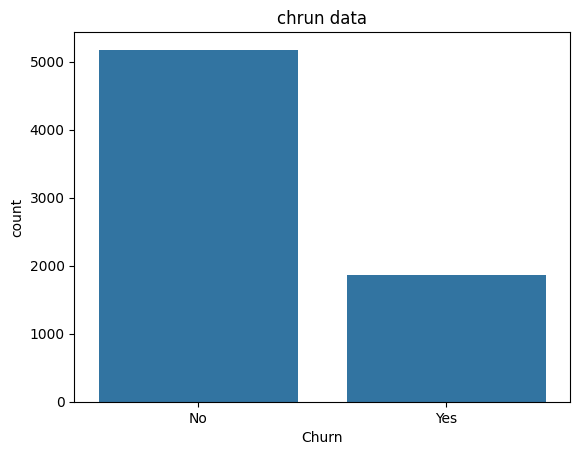

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Churn", data=dataset)
plt.title("chrun data")
plt.show()

## **churn vs tenure**

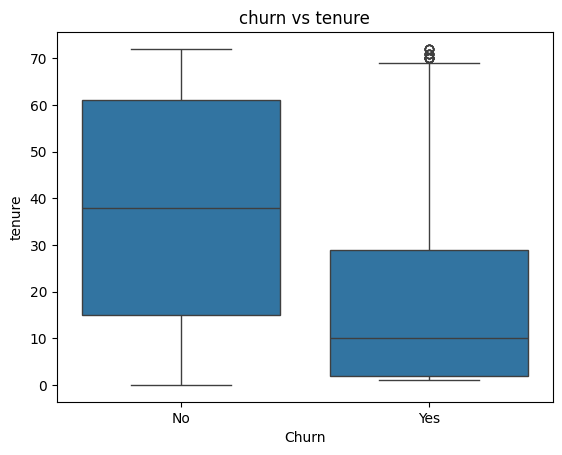

In [161]:
sns.boxplot(x = 'Churn' , y ='tenure' , data = dataset)
plt.title("churn vs tenure")
plt.show()

#Customers with low tenure churn more

## **Churn vs Contract Type**

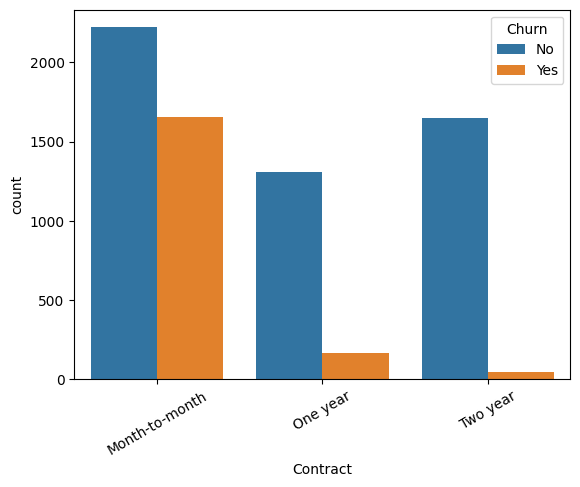

In [162]:
sns.countplot(x='Contract', hue='Churn', data=dataset)
plt.xticks(rotation=30)
plt.show()

#Month-to-month contracts churn the most

## **data cleaing**

In [163]:

dataset.drop(columns = ['customerID'], inplace=True)


dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'] , errors='coerce')
dataset['TotalCharges'].isnull().sum()

dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].median())

dataset["Churn"] = dataset["Churn"].map({"Yes": 1, "No": 0})


In [164]:
print(dataset)

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
2       Male              0      No         No       2          Yes   
3       Male              0      No         No      45           No   
4     Female              0      No         No       2          Yes   
...      ...            ...     ...        ...     ...          ...   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7041    Male              1     Yes         No       4          Yes   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1      

## **data cleaing**

## **Feature / Target Split**

In [165]:
x = dataset.iloc[: , :-1]
y = dataset.iloc[: ,-1]


In [166]:
print(x)

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
2       Male              0      No         No       2          Yes   
3       Male              0      No         No      45           No   
4     Female              0      No         No       2          Yes   
...      ...            ...     ...        ...     ...          ...   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7041    Male              1     Yes         No       4          Yes   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1      

In [167]:
print(y)

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64


In [168]:
x = pd.get_dummies(x,drop_first=True )

feature_columns = x.columns.tolist()

import joblib
joblib.dump(feature_columns, "models/feature_columns.pkl")



['models/feature_columns.pkl']

### **Train-Test Split**

In [169]:
from sklearn.model_selection import train_test_split
x_train ,x_test , y_train , y_test = train_test_split(x,y,test_size = 0.3 , random_state=42,stratify=y)

In [170]:
print(y_train)

5557    0
2270    1
6930    1
2257    0
898     1
       ..
4250    0
1488    0
6303    0
2710    0
5639    0
Name: Churn, Length: 4930, dtype: int64


## **Baseline Model – Logistic Regression**

In [171]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("models", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

pipeline.fit(x_train, y_train)

,steps,"[('scaler', ...), ('models', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [172]:
import os 
import joblib

os.makedirs("models" , exist_ok=True)

joblib.dump(pipeline, "models/churn_pipeline.pkl")


['models/churn_pipeline.pkl']

In [173]:
from pydantic import BaseModel

class CustomerData(BaseModel):
    tenure: float
    MonthlyCharges: float
    TotalCharges: float
    Contract_One_year: int
    Contract_Two_year: int
    InternetService_Fiber_optic: int

# **Predictions**

In [174]:
y_pred = pipeline.predict(x_test)
y_prob = pipeline.predict_proba(x_test)[:, 1]


## **Evaluation**

In [175]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1552
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.76      2113



ROC-AUC: 0.8442656936251539


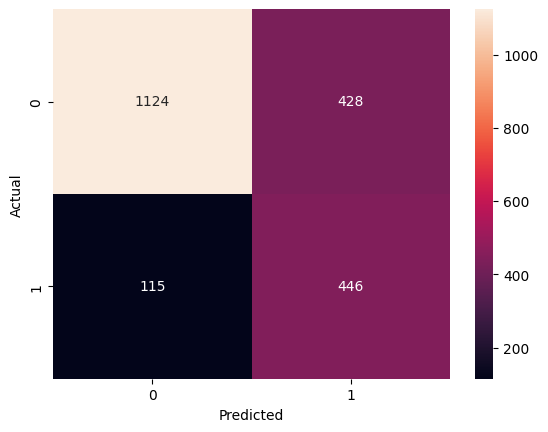

In [176]:

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [177]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
     n_estimators= 200 ,
     max_depth=10,
     class_weight='balanced',
     min_samples_leaf=10,
     random_state=42
)

rf.fit(x_train,y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [178]:
y_pred_rf = rf.predict(x_test)
y_prob_rf = rf.predict_proba(x_test)[:, 1]

In [179]:
print(y_prob_rf)

[0.7537085  0.04915177 0.82780795 ... 0.16247704 0.61079182 0.07633451]


In [180]:
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

roc_auc = roc_auc_score(y_test, y_prob_rf)
print("Random Forest ROC-AUC:", roc_auc)


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.76      0.82      1552
           1       0.54      0.78      0.64       561

    accuracy                           0.76      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.76      0.78      2113

Random Forest ROC-AUC: 0.8434479344690078


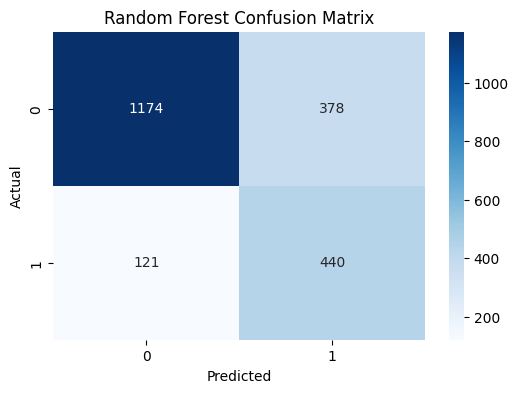

In [181]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


In [182]:
comparison = pd.DataFrame({
    "Models": ["Logistic Regression", "Random Forest"],
    "Recall (Churn)": [0.80, "<RF_RECALL>"],
    "Precision (Churn)": [0.51, "<RF_PRECISION>"],
    "ROC-AUC": [0.84, round(roc_auc, 3)]
})

print(comparison)


                Models Recall (Churn) Precision (Churn)  ROC-AUC
0  Logistic Regression            0.8              0.51    0.840
1        Random Forest    <RF_RECALL>    <RF_PRECISION>    0.843


In [183]:
train_pred = rf.predict(x_train)
train_prob = rf.predict_proba(x_train)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_prob))
print("Test ROC-AUC:", roc_auc)



Train ROC-AUC: 0.8975927774034653
Test ROC-AUC: 0.8434479344690078


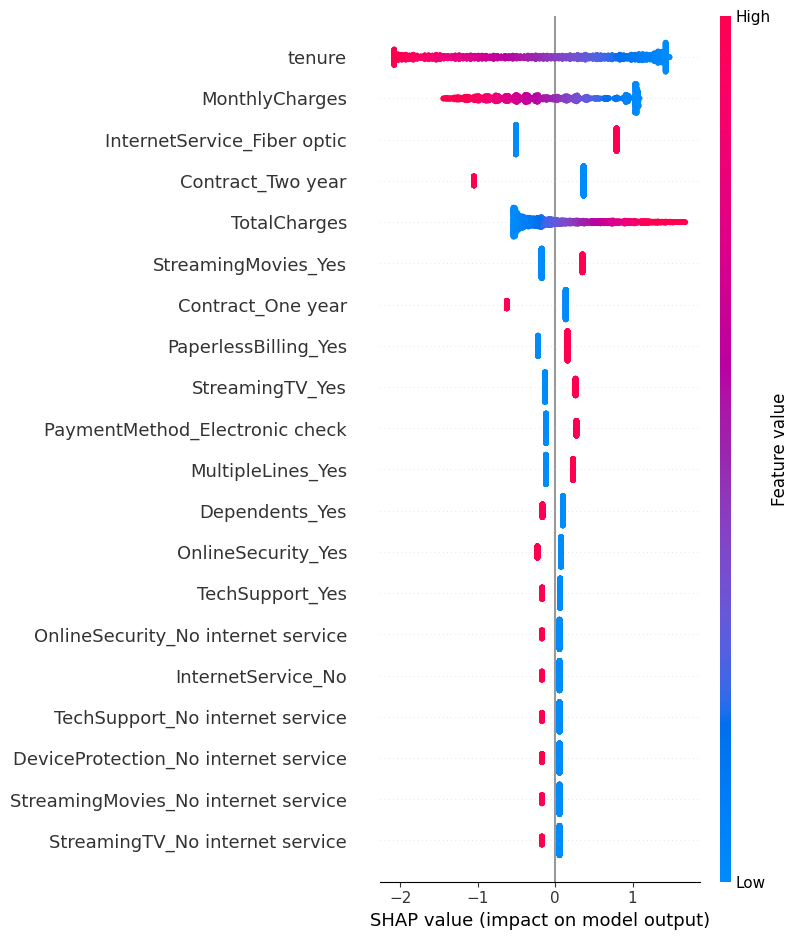

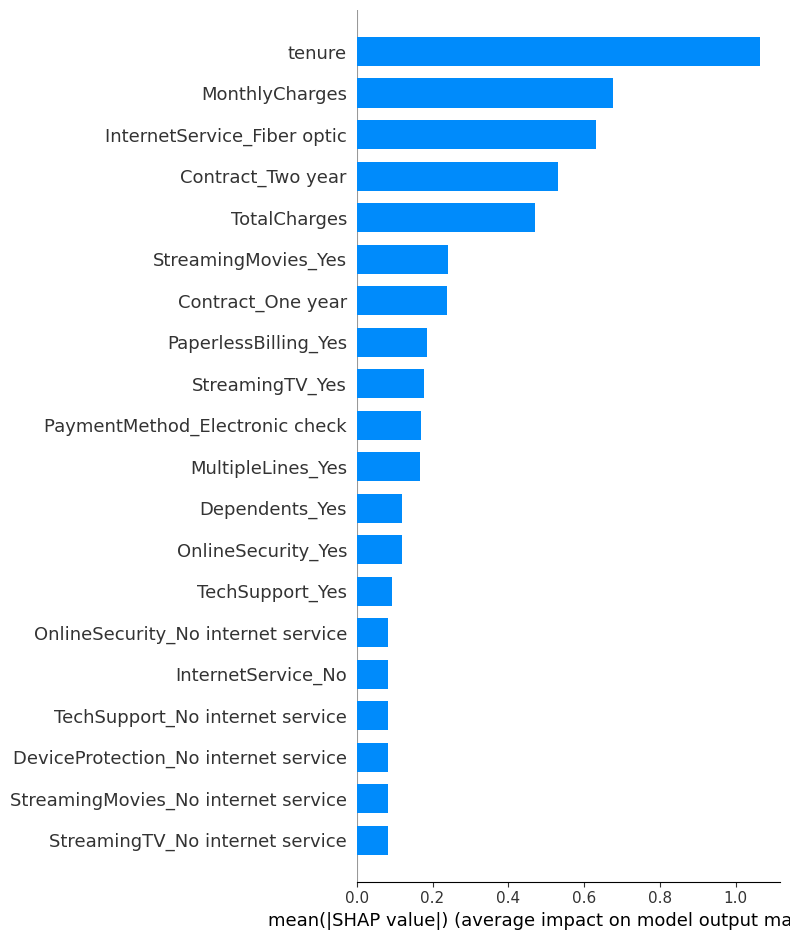

In [184]:
import shap

# Extract trained logistic regression from pipeline
models = pipeline.named_steps["models"]
scaler = pipeline.named_steps["scaler"]

# Scale training data exactly how pipeline does
x_train_scaled = scaler.transform(x_train)

explainer = shap.LinearExplainer(models, x_train_scaled)

# Scale test data too
x_test_scaled = scaler.transform(x_test)

shap_values = explainer.shap_values(x_test_scaled)

shap.summary_plot(shap_values, x_test)

shap.summary_plot(shap_values, x_test, plot_type="bar")

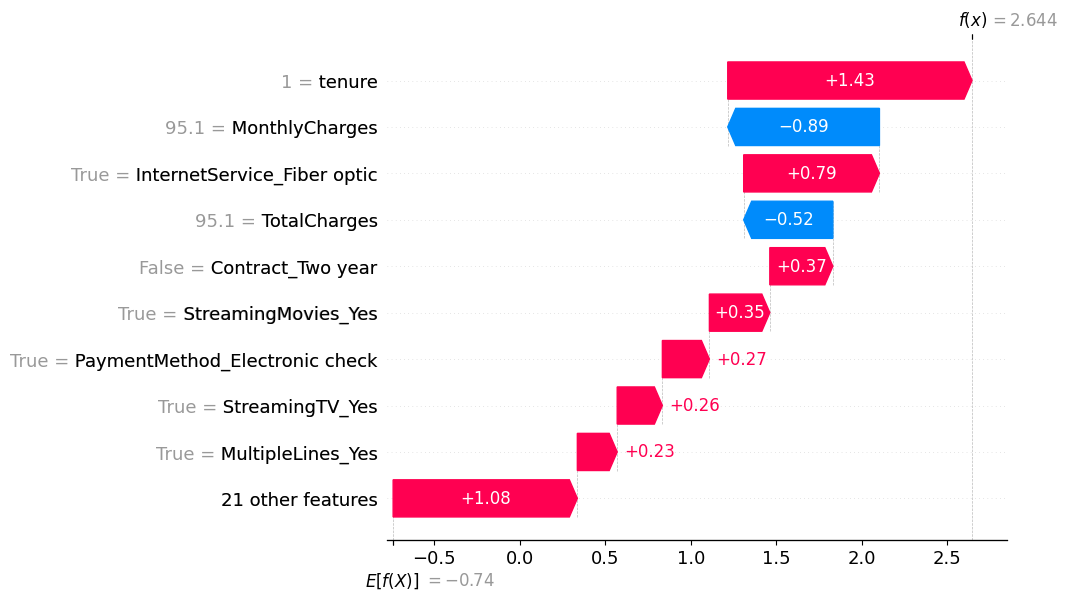

In [185]:
import numpy as np 
high_risk_index = np.argmax(pipeline.predict_proba(x_test)[:, 1])
exp = shap.Explanation(
    values=shap_values[high_risk_index],
    base_values=explainer.expected_value,
    data=x_test.iloc[high_risk_index],
    feature_names=x_test.columns
)

shap.plots.waterfall(exp)


In [186]:
print(pipeline.feature_names_in_)



['SeniorCitizen' 'tenure' 'MonthlyCharges' 'TotalCharges' 'gender_Male'
 'Partner_Yes' 'Dependents_Yes' 'PhoneService_Yes'
 'MultipleLines_No phone service' 'MultipleLines_Yes'
 'InternetService_Fiber optic' 'InternetService_No'
 'OnlineSecurity_No internet service' 'OnlineSecurity_Yes'
 'OnlineBackup_No internet service' 'OnlineBackup_Yes'
 'DeviceProtection_No internet service' 'DeviceProtection_Yes'
 'TechSupport_No internet service' 'TechSupport_Yes'
 'StreamingTV_No internet service' 'StreamingTV_Yes'
 'StreamingMovies_No internet service' 'StreamingMovies_Yes'
 'Contract_One year' 'Contract_Two year' 'PaperlessBilling_Yes'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check'
 'PaymentMethod_Mailed check']


In [187]:
import joblib
joblib.dump(x.columns.tolist(), "models/feature_columns.pkl")


['models/feature_columns.pkl']